# Predicting The Past
-----------------------------------------------------------------------------------------------------------------------------
*Welcome to the third part of the project. In the [first part](https://github.com/nikosga/theHobbyist/blob/master/thesis%20project/Part%201__Data%20Cleaning.ipynb) two datasets were created. The first one was used for the [second part](https://github.com/nikosga/theHobbyist/blob/master/thesis%20project/Part%202__Regression%20Techniques.ipynb) of the project and the second dataset is tailored for the needs of this part. The obstacle we had to overcome with the second dataset was the fact that while some features were appearing in some years, they were absent in others (full of NAs). The problem was solved by keeping the features that were common in all years from 1990-2014. As you probably have guessed by now, the target is to predict the happiness levels of people from different countries all the way back to 1990. But why 1990? Why not even farther? The reason is that as years go by, the prediction moves farther from the truth. In our case happiness is a subjective variable. That means people were asked how they feel and each one makes different sense of happiness. Of course when the responses are aggregated the result can be considered reliable as psychologists argue. There are others who believe the [opposite](http://happierhuman.com/measuring-happiness/). But no matter what everyone believes no one can argue that variables play the same role in all years. For example one variable causing problems is the % of internet users. Now we don't have data from happiness in the 90's but I am not willing to assume that people were miserable in the 70's or 60's because they didn't have Facebook or Tinder. Surely, this variable can be used as an instrument for gdp or access to education, but only in the time period it exists. Another problem is the fact that as we move in the past even more data are missing and that will drop the prediction power even more. As you were reading I was charging the time machine. It's now ready so sit back and enjoy... *

In [1]:
#Importing modules and data
from sklearn.preprocessing import scale
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv("C:\\Users\\nikos\\Desktop\\thesisdata\\2005to2014train.csv")
test = pd.read_csv("C:\\Users\\nikos\\Desktop\\thesisdata\\1990to2004test.csv")

First thing we are going to attempt will be to create a model using the data from 2014, to predict happiness in the years 2005-2013. After doing so we are going to evaluate the model and create a new one to do the same thing (using a part of the dataset from 2005 to 2014) to predict the past (back to 1990). Why two models? Using just one model with 2014 data introduces a constraint in the data that will be used. That means that since I used only 2014 data to construct the model and test it in the years 2005-2013, I would have to use the same model to predict from 2004 and backwards. But why do that when we have data from 2005 to 2014 to use for training? We could maneuver this issue using just one model and evaluating it using cross-validation or train-test split. But that yields another serious problem. Since the data we are dealing with are of macroeconomic nature, changes between the years exist but are not that significant. So using traditional train-validation split to evaluate the model would result in overfitting (R^2~0.89). So we will introduce the 2-model methodology. By using this methodology we are making assumptions that seem logical but do not necessarily hold. For example we assume that the overall gain in predictive power (by using more data) will be about equal to the loss we will have for making predictions in a different but near timeframe. For example, if we used internet users to train a model today and use it to predict happiness in 1800 would result in predicting absolute misery since internet [only communicated 1% of the information](https://en.wikipedia.org/wiki/History_of_the_Internet) flowing through telecommunications networks in the year 1993 and rapidly increased afterwards(more than 97% by 2007). Simply put, we assume that the relation of happiness with the feautures we used didn't change through time.

In [2]:
trainset = train[(train.Year==2014) | (train.Year==2012)| (train.Year==2010)
                | (train.Year==2008) | (train.Year==2006)]
crossvalset = train[(train.Year==2005) | (train.Year==2007) | (train.Year==2009)
                  | (train.Year==2011) | (train.Year==2013)]

As mentioned Internet users should be removed from the equation. 

In [3]:
internet = 'Internet users (per 100 people)'
Xtrain = trainset.drop(["Country","Life Ladder",internet,"Year"],axis=1)
Xcrossval = crossvalset.drop(["Country","Life Ladder",internet,"Year"],axis=1)
Xtest = test.drop(["Country",internet,"Year"],axis=1)
ytrain = trainset.iloc[:,1]
ycrossval = crossvalset.iloc[:,1]
#The model
params = {'n_estimators': 2000, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls','random_state':2}
clf = GradientBoostingRegressor(**params)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xcrossval)
r2_score(ycrossval, ypred)

0.86726231833069012

Question : _"Does global happiness change over time?"_

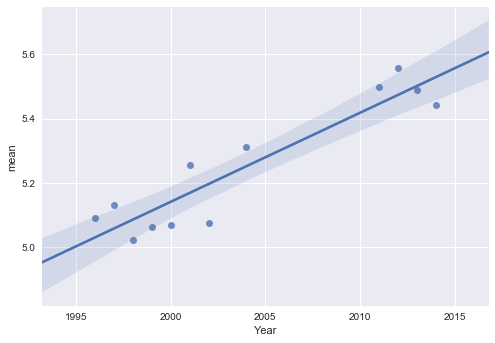

In [4]:
#the prediction
prediction = clf.predict(Xtest)
yy = train.iloc[:,1]
truedf=pd.DataFrame([yy,train.Year,train.Country]).transpose().dropna()
truedf = truedf.rename(columns={'Life Ladder':'value'})
truedf['type'] = 'true'
preddf=pd.DataFrame([prediction,test.Year,test.Country]).transpose().dropna()
preddf = preddf.rename(columns={0:'value',1:'Year',2:'Country'})
preddf['type'] = 'predicted'
seriesdf = pd.concat([truedf,preddf])
seriesdf = seriesdf.sort_values("Year")
list1 =[]
for year in range(1990,2015):
    list1.append(seriesdf.value[seriesdf.Year==year].mean())
globalhappy = pd.DataFrame()
globalhappy["mean"]=list1
globalhappy["Year"]=set(seriesdf.Year)
ncount = []
for year in range(1990,2015):
    ncount.append(seriesdf[seriesdf.Year==year].shape[0])
globalhappy["ncountries"] = ncount
sns.regplot(x="Year",y="mean",data=globalhappy[(globalhappy.ncountries>90)],order=1)

The predicted world happiness is increasing in the specific timeframe. These are not the real happiness values so we can cannot state with certainty that people are becoming happier. Finishing our analysis let's take a look at the predicted happiness for some European countries. In the following plot the points from 2005 and later are the true values, while the previous points are predictions. Observe that from 1990-1997 the predicted curves seem to be getting closer to each other and that may be due to weak accuracy. 

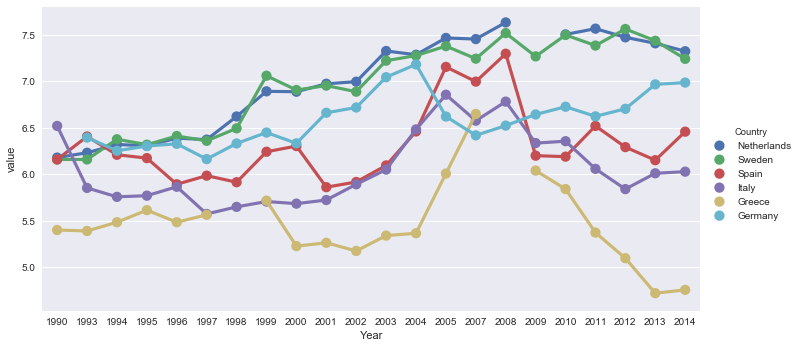

In [6]:
#plotting the final results
yy = train.iloc[:,1]
truedf=pd.DataFrame([yy,train.Year,train.Country]).transpose().dropna()
truedf = truedf.rename(columns={'Life Ladder':'value'})
truedf['type'] = 'true'
preddf=pd.DataFrame([prediction,test.Year,test.Country]).transpose().dropna()
preddf = preddf.rename(columns={0:'value',1:'Year',2:'Country'})
preddf['type'] = 'predicted'
seriesdf = pd.concat([truedf,preddf])
seriesdf = seriesdf.sort_values("Year")
sns.factorplot(data=seriesdf.loc[(seriesdf.Country=="Greece")
                               | (seriesdf.Country=="Sweden")
                               | (seriesdf.Country=="Germany")
                               | (seriesdf.Country=="Spain")
                               | (seriesdf.Country=="Netherlands")
                               | (seriesdf.Country=="Italy")], x='Year', y='value',hue="Country",size=5,aspect=2)

# _The end_
-----------------------------------------------------------------------------------------------------------------------------